In [21]:
clear()

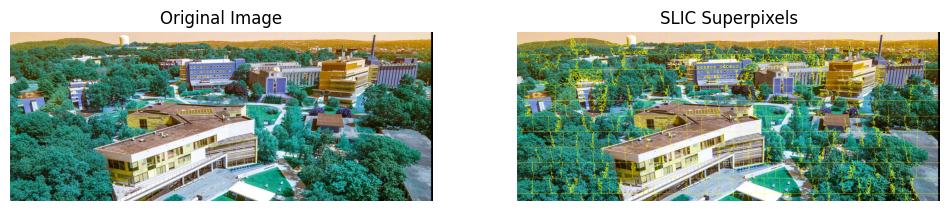

In [22]:
import numpy as np
from skimage.color import rgb2lab
import matplotlib.pyplot as plt
from PIL import Image

def calculate_distances(image_lab, centroids, S, m, labels):
    h, w = image_lab.shape[:2]
    distances = 1e10 * np.ones((h, w), np.float64)

    for cent in centroids:
        # Get the centroid position
        c_y, c_x = int(cent[0]), int(cent[1])
        # Define a window around the centroid
        min_y = int(max(c_y - S, 0))
        max_y = int(min(c_y + S, h))
        min_x = int(max(c_x - S, 0))
        max_x = int(min(c_x + S, w))

        window = image_lab[min_y:max_y, min_x:max_x]

        # Compute the LAB distance
        d_lab = np.linalg.norm(window - cent[3:], axis=2)
        # Compute the xy distance
        y, x = np.ogrid[min_y:max_y, min_x:max_x]
        d_xy = np.sqrt((y - c_y)**2 + (x - c_x)**2)
        # Compute the total distance
        d = d_lab + (d_xy / S) * m  # m is the compactness parameter
        # Assign pixels to the nearest centroid
        mask = d < distances[min_y:max_y, min_x:max_x]
        distances[min_y:max_y, min_x:max_x][mask] = d[mask]
        labels[min_y:max_y, min_x:max_x][mask] = cent[4]

    return distances, labels

def update_centroids(image_lab, centroids, labels):
    for i, cent in enumerate(centroids):
        # Get all pixels associated with this centroid
        pixels = image_lab[labels == cent[4]]
        if len(pixels) > 0:
            # Update centroid to the mean LAB values of the cluster
            mean_values = np.mean(pixels, axis=0)
            centroids[i][3:] = mean_values
    return centroids

def slic(image, K, m=10, max_iterations=10):
    h, w = image.shape[:2]
    S = int((h * w / K)**0.5)  # Grid interval
    image_lab = rgb2lab(image)
    # Initialize centroids
    centroids = []
    for y in range(S // 2, h, S):
        for x in range(S // 2, w, S):
            cent = [y, x] + list(image_lab[y, x]) + [len(centroids)]
            centroids.append(cent)
    centroids = np.array(centroids)

    # Initialize labels and distances
    labels = -1 * np.ones((h, w), np.int64)
    distances = 1e10 * np.ones((h, w), np.float64)

    for i in range(max_iterations):
        distances, labels = calculate_distances(image_lab, centroids, S, m, labels)
        centroids = update_centroids(image_lab, centroids, labels)

    # Convert labels to a segmentation map
    segments = labels
    return segments

def draw_boundaries(image, segments):
    # Create an image to draw the boundaries on
    boundary_image = image.copy()

    # Find boundaries between superpixels
    boundaries = np.zeros(segments.shape, dtype=bool)
    boundaries[:-1, :] |= (segments[:-1, :] != segments[1:, :])
    boundaries[:, :-1] |= (segments[:, :-1] != segments[:, 1:])

    # Draw the boundaries on the image
    boundary_image[boundaries] = [255, 255, 0]  # Yellow color for boundaries

    return boundary_image

# Load image
image_path = 'Brandeis_campus.jpg'
image = cv2.imread(image_path)

# Perform SLIC segmentation
K = 300  # The desired number of superpixels
segments = slic(image, K, m=10)

# Visualization
# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Draw and display superpixel boundaries on the original image
segmented_image = draw_boundaries(image, segments)
plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("SLIC Superpixels")
plt.axis('off')
plt.show()

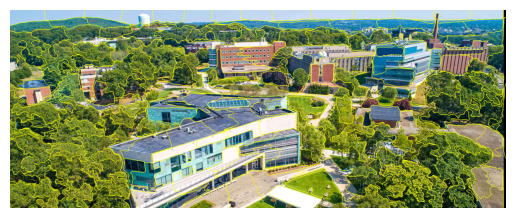

In [23]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
import argparse

# load the image and convert it to a floating point data type
image = img_as_float(io.imread('Brandeis_campus.jpg'))

# apply SLIC and extract the supplied number of segments
segments = slic(image, n_segments = 250, sigma = 5)

# Plot results
fig = plt.figure("Superpixels -- %d segments%")
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image, segments))
plt.axis("off")

plt.savefig('Skimage results')
plt.show()

 Using the skimage SLIC is more straightforward to use and requires fewer lines of code. Moreover, as one can see from the result, the skimage library is likely to be more optimized for performance.

 However, it is less flexible when it comes to customizing the code. When precise adjustments are needed, it is hard to modify the code.

 Using Custom SLIC is good that one can understand the mechanism of SLIC superpixel and can be modified easily.

 But also it may not perform well as optimized code unless doing careful optimization. It is apparant that the skimage SLIC performs great but custom one does not. The coder has to try out different values for parameters such as K and m, which is time consuming.